In [307]:
import numpy as np
import matplotlib.pyplot as plt

# Part A

In [308]:
N = 10000
norm_dist = np.random.normal(1, 1, (N,))
weib = np.random.weibull(0.3, (N,))
pareto = (np.random.pareto(0.5, (N,)) + 1) * (1/3)


In [309]:
def make_plots_A(dist):
    plt.plot(np.arange(1, 21, 1), np.cumsum(dist)[:20])
    plt.title("n->20")
    plt.xlabel("n")
    plt.ylabel("cumsum")
    plt.show()
    plt.plot(np.arange(N), np.cumsum(dist))
    plt.title("All n")
    plt.xlabel("n")
    plt.ylabel("cumsum")
    plt.show()

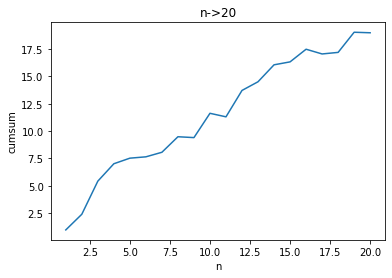

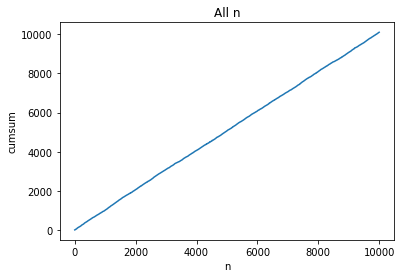

In [310]:
make_plots_A(norm_dist)

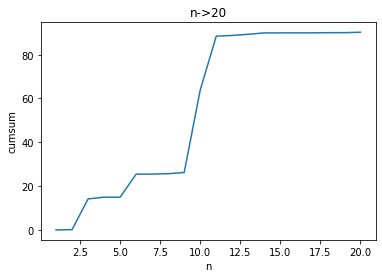

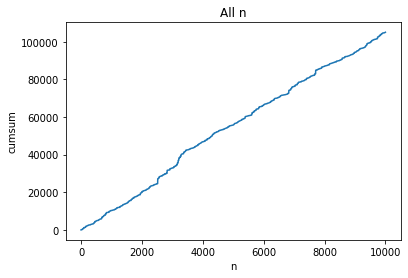

In [311]:
make_plots_A(weib)

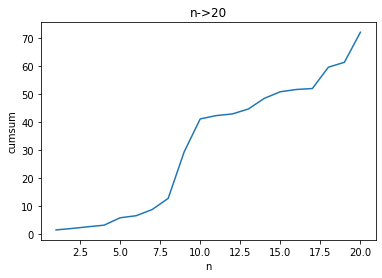

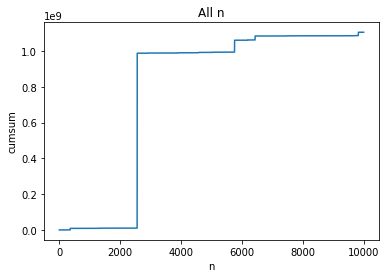

In [312]:
make_plots_A(pareto)

# Part B

In [322]:
def make_plots_B(dist, mean, distribution):
    cumsum = np.cumsum(dist)
    deviations = (cumsum - np.arange(1, N+1, 1) * mean) / np.sqrt(np.arange(1, N+1, 1))
    plt.plot(np.arange(1, N+1, 1), deviations)
    plt.title(distribution)
    plt.show()

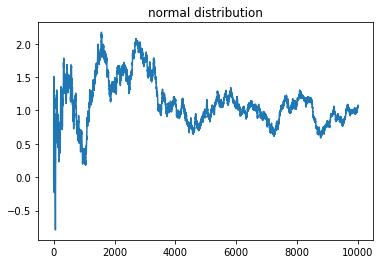

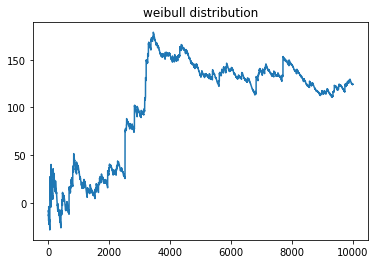

In [323]:
make_plots_B(norm_dist, 1, "normal distribution")
make_plots_B(weib, 9.26053, "weibull distribution")

# Part C

In [316]:
def frac(dist):
    rs = (np.arange(0.01, 0.21, 0.01) * N).astype(int)
    sorted_dist = sorted(dist, reverse=True)
    cumsum = np.cumsum(sorted_dist)
    fracs = np.array([cumsum[r] for r in rs])
    fracs = fracs / np.sum(dist) * 100
    return fracs
    

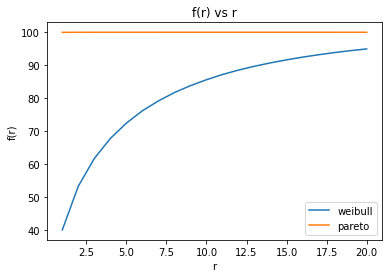

In [317]:
fracs_weib = frac(weib)
fracs_pareto = frac(pareto)
plt.plot(np.arange(1, 21, 1), fracs_weib, label="weibull")
plt.plot(np.arange(1, 21, 1), fracs_pareto, label="pareto")
plt.title("f(r) vs r")
plt.xlabel("r")
plt.ylabel("f(r)")
plt.legend()

# Part D

In [318]:
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [319]:
# Note: Feel free to modify this template as you wish or build your own from scratch.
# This is a tricky problem to implement so we hope we are helping by providing a template!

def pdf(data, dx=1):
    '''Takes an array with random samples from a distribution, 
    and creates an approximate PDF of points, to use when frequency
    Returns a tuple of two vectors x, y where 
    y_i = P(x_i - dx/2 <= data < x_i + dx/2)'''
  
    low, high = np.min(data), np.max(data)
    x, y = [], []
    
    for d in data:
        i = int((d + dx / 2 - low) / dx)
        xi = low + i * dx
        if xi in x:
            y[x.index(xi)] += 1
        else:
            x.append(xi)
            y.append(1)
    
    return np.array(x), np.array(y)
    
def ccdf(data):
    '''Takes an array with random samples from a 
    distribution, and creates an approximate CCDF 
    (complementary CDF) of points. Returns a tuple of 
    two vectors x, y where y_i = P(data > x_i)'''
    # TODO: Complete this function
    
    # Use this when creating the rank plot
    # HINT: To generate an approximate CDF (not CCDF), one would sort the random samples and 
    # return those as the x values, and then create a range from 1 to n
    # (scaled by 1/n) for the y values. How does this change when creating a CCDF?
    x = 1-np.sort(data)
    y = [i / N for i in range(1, N+1, 1)]
    return x, y

def keep_positive(data):
    '''Takes an array with random samples from
    a distribution, and filters our negative and 
    zero entries (in both x and y) in data'''
    # TODO: Complete this function
    for dist in range(len(data)):
        x, y = data[dist]
        x = np.array(x)
        y = np.array(y)
        x_pos = x > 0
        y_pos = y > 0
        x = x[x_pos & y_pos]
        y = y[y_pos & x_pos]
        data[dist] = (x, y)
    return data
 
def non_outliers(x, m):
    '''Takes an array x of data and an integer m,
    and returns a list z of boolean values such 
    that z_i indicates whether the mean-centered 
    value x_i is within m std devs of the values in x'''
    # TODO: Complete this function
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_centered = x - x_mean
    z = np.abs(x_centered) <= m * x_std
    return z
    
def reject_outliers(data, m):
    '''Takes an array of data (data here is a 
    tuple (x,y), where x and y are arrays: 
    in the form resulting from pdf() or ccdf(), for example)
    and an integer m, and removes outliers from the data'''
    # TODO: Complete this function 
    
    # Note that since we are plotting on log-log scale
    # Removing outliers should happen AFTER we move to log-log scale
    
    # HINT: This function returns the (x, y) tuples in data that 
    # are not outliers (non_outliers() is helpful here)
    
    # HINT: You must set m to a default value that defines how many 
    # standard deviations away an outlier is. We are testing that 
    # these distributions are heavy-tailed, so too tight of a range 
    # won't be helpful.
    x, y = data
    m = 2
    x_non = non_outliers(x, m)
    y_non = non_outliers(y, m)
    x = x[x_non & y_non]
    y = y[x_non & y_non]
    return (x, y)
    
def linear_regression(X, y):
    '''Takes (one-dimensional) training data X 
    and labels y and fits the simple linear regression 
    model y = mX + b, and computes the coefficient 
    of determination (r^2). Returns a tuple (m, b, r^2)'''
    # TODO: Complete this function 
    reg = LinearRegression()
    reg.fit(X.reshape(-1, 1), y)
    ypred = reg.predict(X.reshape(-1, 1))
    return (reg.coef_, reg.intercept_, r2_score(y, ypred))

def make_graphs_d(data, title, labels, ylabel='', xlabel=''):
    """
    Build respective PDF/CCDF for all three distributions
    Attempts to create a best-fit line
    And plots this line alongside the points
    data: List of pdf() outputs from all 3 distributions
    title: Either 
        Frequency plot (PDF)
        Rank plot (CCDF)
    labels: List of distribution names
        i.e. ["Normal, Weibull, Pareto"]
    """
    # General plotting function for points, as well as best-fit line
    
    for (X, y), label in zip(data, labels):
        m, b, r2 = linear_regression(X, y)
        plt.scatter(X, y, label=label, s=1)
        plt.plot(X, b + m * X, label='y = %.2f * x + %.2f, r2 = %.3f' % (m, b, r2))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

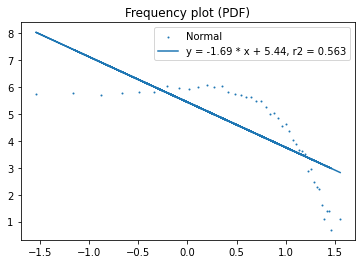

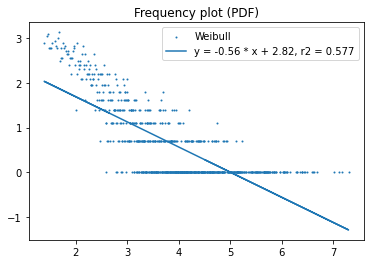

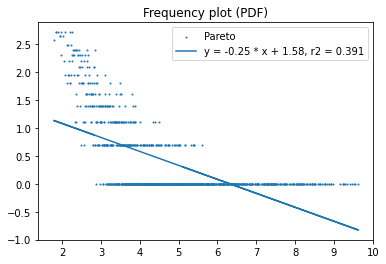

In [320]:
# Concatenate data into one list to reduce code repetition
Xi = [norm_dist, weib, pareto]
names = ["Normal", "Weibull", "Pareto"]

# Build the PDF and turn it into a log-log scale,
# first removing all negative values and corresponding indices
# TODO: When (if at all) do we remove outliers here? 
# Before or after we convert to log-scale?
data = [pdf(Xi[i], dx=0.1) for i in range(3)]
data = keep_positive(data)
data = [(np.log(X), np.log(y)) for (X, y) in data]
data = [reject_outliers(data[i], 4) for i in range(len(data))]


# Plot the frequencies
make_graphs_d(data, 'Frequency plot (PDF)', names)

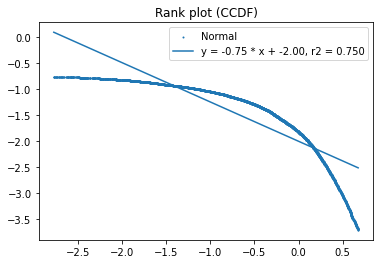

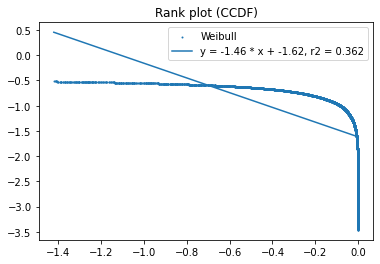

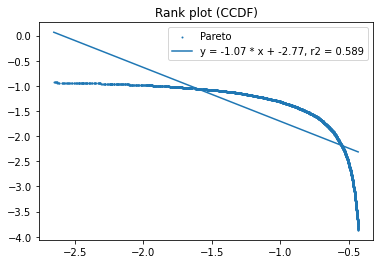

In [321]:
data = [ccdf(Xi[i]) for i in range(3)]

# Build the CCDF and turn it into a log-log scale,
# first removing all negative values and corresponding indices
# TODO: Do we remove outliers here?
data = keep_positive(data)
data = [(np.log(X), np.log(y)) for (X, y) in data]
data = [reject_outliers(data[i], 4) for i in range(len(data))]
# Plot the ranks
make_graphs_d(data, 'Rank plot (CCDF)', names)

For the plots, 

Filtering out outliers makes sense because on a log scale, big outliers can mess with the graph ranges. Small outliers become big outliers in log, while big outliers become even bigger.

We see that the normal distribution is not heavy-tailed, but the other 2 are. It's easier to see this because best fits have better linearity for normal, but they are worse for weibull and pareto, and we see a sharp drop off in the points in the emperical ccdf. 